<a href="https://colab.research.google.com/github/VKSi/2021_02_GB_PyTorch/blob/main/HW_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> “Фреймворк PyTorch для разработки искусственных нейронных сетей”</center></h1>

<h1><center>PyTorch: водное занятие</center></h1>

**Домашнее задание: **       
1) Добиться вразумительного результата от модели, собранной на занятии (7 угаданныx картинок из 10 предложенных на семинаре).     
 Варианты изменений:     
 изменение слоёв и их количества;      
 изменение метода оптимизации;      
 изменение процесса обучения;      
 для продвинутых: преобразование данных transform

2) Переписать данный туториал на pytorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru


### Установка

In [ ]:
!pip3 install torch torchvision

In [ ]:
pip show torch

Name: torch
Version: 1.8.0+cu101
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, typing-extensions
Required-by: torchvision, torchtext, fastai


In [ ]:
pip show torchvision

Name: torchvision
Version: 0.9.0+cu101
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: torch, numpy, pillow
Required-by: fastai


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


### Подключение 

In [ ]:
import torch
import torchvision
from torch.autograd import Variable
from torch import nn 
from torch import optim
import numpy as np
import torch.nn.functional as F

## Часть, сделанная на вебинаре

##### Функция для вывода данных о тензоре:

In [ ]:
def print_tens_info(tensor):
    print("X :\n%s\n" % tensor)
    print("X количество измерений:\n%s\n" % tensor.dim())
    print("X размеры : ",  tensor.size())
    print("X тип : %s\n" % (tensor.type()))
    print("Добавим 10 :\n%s\n" % (tensor + 10))
#     print("Среднее по строчке :\n%s\n" % (tensor.mean(axis=-1)))
#     print("Среднее по столбцу :\n%s\n" % (tensor.mean(axis=0)))
    

#### Загрузка существующего датасета:

Теперь посмотрим как все это работает с помощью реального датасета:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/PyTorch/'
DATA_PATH = PATH + 'data/'

In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt ### воспользуемся для отображения изображения

Будем рассматривать датасет CIFAR10, который представлен в библиотеке torchvision. 

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, # путь куда будут скачиваться наши данные(если download=true), 
                                                                 # или где лежат наши данные(dowload=False)
                                             train=True, # говорим что используем датасет для обучения  
                                             transform=transforms.ToTensor(), # важная строчка: здесь мы преобразуем данные
                                                                                # из датасета в формат тензоров из торч
                                             download=False)


image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([3, 32, 32])
6


Что бы вывести, наше изображение, нам нужно воспользоваться функцией permute и поменять размерности:

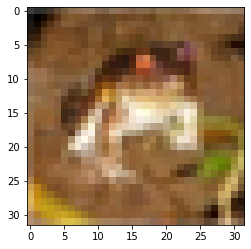

In [ ]:
plt.imshow(image.permute(1, 2, 0).numpy())

Теперь скачав датасет, нам нужно его как-то оформить для загрузки в нашу модель. Делается это с помощью DataLoader:

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [ ]:
test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False,
                                       download=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Определим следующую модель:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)  # 14x14x6 -> 5x5x16
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 x3 -> 28x28 x6 -> 14x14 x6
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 x6 -> 10x10 x16 -> 5x5 x16
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net().to('cuda')

In [ ]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def learning(net, _train_loader, _optimizer,  _criterion):
  for epoch in range(10):  # 10 эпох 
      running_loss = 0.0 # Для вывода процесса обучения
      for i, data in enumerate(_train_loader, 0):
          inputs, labels = data[0], data[1]
          inputs, labels = inputs.to('cuda'), labels.to('cuda')
          # Обнуляем градиент
          _optimizer.zero_grad()
      
          # Делаем предсказание
          outputs = net(inputs)
          # Рассчитываем лосс-функцию
          loss = _criterion(outputs, labels)
          # Делаем шаг назад по лоссу
          loss.backward()
          # Делаем шаг нашего оптимайзера
          optimizer.step()

          # выводим статистику о процессе обучения
          running_loss += loss.item()
          if i % 300 == 0:    # печатаем каждые 300 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
              running_loss = 0.0

  print('Training is finished!')
  return net

In [ ]:
net = learning(net, train_loader, optimizer,  criterion)

[1,     1] loss: 0.001
[1,   301] loss: 0.346
[1,   601] loss: 0.345
[2,     1] loss: 0.001
[2,   301] loss: 0.345
[2,   601] loss: 0.345
[3,     1] loss: 0.001
[3,   301] loss: 0.343
[3,   601] loss: 0.337
[4,     1] loss: 0.001
[4,   301] loss: 0.309
[4,   601] loss: 0.302
[5,     1] loss: 0.001
[5,   301] loss: 0.299
[5,   601] loss: 0.293
[6,     1] loss: 0.001
[6,   301] loss: 0.287
[6,   601] loss: 0.279
[7,     1] loss: 0.001
[7,   301] loss: 0.271
[7,   601] loss: 0.266
[8,     1] loss: 0.001
[8,   301] loss: 0.257
[8,   601] loss: 0.255
[9,     1] loss: 0.001
[9,   301] loss: 0.246
[9,   601] loss: 0.242
[10,     1] loss: 0.001
[10,   301] loss: 0.236
[10,   601] loss: 0.232
Training is finished!


In [ ]:
def metrics(_net, _t_loader, label):
  counter_pos = 0
  counter_tot = 0
  for i, data in enumerate(_t_loader, 0):
    inputs, labels = data[0], data[1]
    inputs, labels = inputs.to('cuda'), labels.to('cuda')
    outputs = _net(inputs)
    for j in range(len(labels)):
      counter_tot += 1
      counter_pos += int(outputs[j].argmax() == labels[j])
  result = np.floor(counter_pos/counter_tot*100)/10
  print(f'На сете {label} правильно предсказано {result} из 10')
  return result

def metrics_train_test(_net, _train_loader, _test_loader):
  return metrics(_net=_net, _t_loader=_train_loader, label='train'), metrics(_net=_net, _t_loader=_test_loader, label='test')

In [ ]:
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

На сете train правильно предсказано 4.5 из 10
На сете test правильно предсказано 4.5 из 10


#### Сохранение модели

In [ ]:
torch.save(net.state_dict(), PATH + 'cifar_net_version_test_intro.pth')

In [ ]:
print("Model state_dict: ")
for param in net.state_dict():
    print(param," \ ", net.state_dict()[param].size())

Model state_dict: 
conv1.weight  \  torch.Size([6, 3, 5, 5])
conv1.bias  \  torch.Size([6])
conv2.weight  \  torch.Size([16, 6, 5, 5])
conv2.bias  \  torch.Size([16])
fc1.weight  \  torch.Size([120, 400])
fc1.bias  \  torch.Size([120])
fc2.weight  \  torch.Size([84, 120])
fc2.bias  \  torch.Size([84])
fc3.weight  \  torch.Size([10, 84])
fc3.bias  \  torch.Size([10])


## 7 из 10

### Увеличим количество фитчей на каждом сверточном слое

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 32x32 x3 -> 28x28 x32 -> 14x14 x32
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 x32 -> 10x10 x64 -> 5x5 x64
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net().to('cuda')

In [ ]:
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.001
[1,   301] loss: 0.346
[1,   601] loss: 0.345
[2,     1] loss: 0.001
[2,   301] loss: 0.344
[2,   601] loss: 0.338
[3,     1] loss: 0.001
[3,   301] loss: 0.307
[3,   601] loss: 0.298
[4,     1] loss: 0.001
[4,   301] loss: 0.285
[4,   601] loss: 0.274
[5,     1] loss: 0.001
[5,   301] loss: 0.256
[5,   601] loss: 0.246
[6,     1] loss: 0.001
[6,   301] loss: 0.236
[6,   601] loss: 0.232
[7,     1] loss: 0.001
[7,   301] loss: 0.222
[7,   601] loss: 0.225
[8,     1] loss: 0.001
[8,   301] loss: 0.217
[8,   601] loss: 0.212
[9,     1] loss: 0.001
[9,   301] loss: 0.207
[9,   601] loss: 0.206
[10,     1] loss: 0.001
[10,   301] loss: 0.200
[10,   601] loss: 0.196
Training is finished!
На сете train правильно предсказано 5.4 из 10
На сете test правильно предсказано 5.3 из 10


### Та же сеть с другим оптимизатором

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 32x32 x3 -> 28x28 x32 -> 14x14 x32
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 x32 -> 10x10 x64 -> 5x5 x64
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net().to('cuda')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.01)
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.001
[1,   301] loss: 27.121
[1,   601] loss: 0.292
[2,     1] loss: 0.001
[2,   301] loss: 0.287
[2,   601] loss: 0.273
[3,     1] loss: 0.001
[3,   301] loss: 0.346
[3,   601] loss: 0.290
[4,     1] loss: 0.001
[4,   301] loss: 0.249
[4,   601] loss: 0.246
[5,     1] loss: 0.001
[5,   301] loss: 0.235
[5,   601] loss: 0.235
[6,     1] loss: 0.001
[6,   301] loss: 0.226
[6,   601] loss: 0.228
[7,     1] loss: 0.001
[7,   301] loss: 0.223
[7,   601] loss: 0.224
[8,     1] loss: 0.001
[8,   301] loss: 0.214
[8,   601] loss: 0.218
[9,     1] loss: 0.001
[9,   301] loss: 0.215
[9,   601] loss: 0.210
[10,     1] loss: 0.001
[10,   301] loss: 0.202
[10,   601] loss: 0.215
Training is finished!
На сете train правильно предсказано 5.1 из 10
На сете test правильно предсказано 4.5 из 10


Результат хуже чем был раньше

### Еще увеличим количество фитчей в первом сверточном слое

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        self.conv1 = nn.Conv2d(3, 256, 5)
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(256, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 32x32 x3 -> 28x28 x256 -> 14x14 x256
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 x256 -> 10x10 x64 -> 5x5 x64
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net().to('cuda')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.001
[1,   301] loss: 0.345
[1,   601] loss: 0.341
[2,     1] loss: 0.001
[2,   301] loss: 0.304
[2,   601] loss: 0.294
[3,     1] loss: 0.001
[3,   301] loss: 0.273
[3,   601] loss: 0.259
[4,     1] loss: 0.001
[4,   301] loss: 0.246
[4,   601] loss: 0.238
[5,     1] loss: 0.001
[5,   301] loss: 0.229
[5,   601] loss: 0.224
[6,     1] loss: 0.001
[6,   301] loss: 0.218
[6,   601] loss: 0.212
[7,     1] loss: 0.001
[7,   301] loss: 0.207
[7,   601] loss: 0.203
[8,     1] loss: 0.001
[8,   301] loss: 0.197
[8,   601] loss: 0.194
[9,     1] loss: 0.001
[9,   301] loss: 0.190
[9,   601] loss: 0.185
[10,     1] loss: 0.001
[10,   301] loss: 0.181
[10,   601] loss: 0.176
Training is finished!
На сете train правильно предсказано 5.8 из 10
На сете test правильно предсказано 5.6 из 10


### Попробуем дообучить эту же сеть

In [ ]:
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.001
[1,   301] loss: 0.172
[1,   601] loss: 0.168
[2,     1] loss: 0.001
[2,   301] loss: 0.165
[2,   601] loss: 0.165
[3,     1] loss: 0.001
[3,   301] loss: 0.158
[3,   601] loss: 0.157
[4,     1] loss: 0.000
[4,   301] loss: 0.150
[4,   601] loss: 0.150
[5,     1] loss: 0.000
[5,   301] loss: 0.147
[5,   601] loss: 0.145
[6,     1] loss: 0.000
[6,   301] loss: 0.141
[6,   601] loss: 0.141
[7,     1] loss: 0.001
[7,   301] loss: 0.135
[7,   601] loss: 0.135
[8,     1] loss: 0.000
[8,   301] loss: 0.130
[8,   601] loss: 0.130
[9,     1] loss: 0.000
[9,   301] loss: 0.127
[9,   601] loss: 0.126
[10,     1] loss: 0.000
[10,   301] loss: 0.122
[10,   601] loss: 0.121
Training is finished!
На сете train правильно предсказано 7.2 из 10
На сете test правильно предсказано 6.7 из 10


На трейне результат уже выше порога. Можно еще попробовать доучить, но в академических целях испробуем еше одну архитектуру

### Уменьшим количество слоев

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        self.conv1 = nn.Conv2d(3, 256, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # 32x32 x3 -> 28x28 x256 -> 14x14 x256
        x = x.view(-1, 256 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x
net = Net().to('cuda')

In [ ]:
net

Net(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.001
[1,   301] loss: 0.310
[1,   601] loss: 0.275
[2,     1] loss: 0.001
[2,   301] loss: 0.252
[2,   601] loss: 0.238
[3,     1] loss: 0.001
[3,   301] loss: 0.223
[3,   601] loss: 0.215
[4,     1] loss: 0.001
[4,   301] loss: 0.205
[4,   601] loss: 0.200
[5,     1] loss: 0.001
[5,   301] loss: 0.192
[5,   601] loss: 0.191
[6,     1] loss: 0.001
[6,   301] loss: 0.183
[6,   601] loss: 0.180
[7,     1] loss: 0.000
[7,   301] loss: 0.174
[7,   601] loss: 0.173
[8,     1] loss: 0.001
[8,   301] loss: 0.166
[8,   601] loss: 0.166
[9,     1] loss: 0.001
[9,   301] loss: 0.160
[9,   601] loss: 0.159
[10,     1] loss: 0.001
[10,   301] loss: 0.155
[10,   601] loss: 0.152
Training is finished!
На сете train правильно предсказано 6.6 из 10
На сете test правильно предсказано 6.2 из 10


Результат лучше, чем для первого обучения "большой" сети

### Дообучим сеть с малым количеством слоев

In [ ]:
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.001
[1,   301] loss: 0.147
[1,   601] loss: 0.146
[2,     1] loss: 0.000
[2,   301] loss: 0.141
[2,   601] loss: 0.141
[3,     1] loss: 0.000
[3,   301] loss: 0.135
[3,   601] loss: 0.134
[4,     1] loss: 0.001
[4,   301] loss: 0.130
[4,   601] loss: 0.131
[5,     1] loss: 0.000
[5,   301] loss: 0.124
[5,   601] loss: 0.125
[6,     1] loss: 0.000
[6,   301] loss: 0.120
[6,   601] loss: 0.119
[7,     1] loss: 0.000
[7,   301] loss: 0.114
[7,   601] loss: 0.116
[8,     1] loss: 0.000
[8,   301] loss: 0.111
[8,   601] loss: 0.108
[9,     1] loss: 0.000
[9,   301] loss: 0.106
[9,   601] loss: 0.106
[10,     1] loss: 0.000
[10,   301] loss: 0.100
[10,   601] loss: 0.101
Training is finished!
На сете train правильно предсказано 7.8 из 10
На сете test правильно предсказано 6.7 из 10


Сеть получилась более "переученной". Результат на трейне вырос значительно, а на тесте - нет

### Уменьшим немного количество ядер. Обучать будем сразу двойное количество эпох

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        self.conv1 = nn.Conv2d(3, 192, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(192 * 14 * 14, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # 32x32 x3 -> 28x28 192 -> 14x14 192
        x = x.view(-1, 192 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x
net = Net().to('cuda')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net = learning(net, train_loader, optimizer,  criterion)
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.001
[1,   301] loss: 0.313
[1,   601] loss: 0.281
[2,     1] loss: 0.001
[2,   301] loss: 0.256
[2,   601] loss: 0.244
[3,     1] loss: 0.001
[3,   301] loss: 0.229
[3,   601] loss: 0.221
[4,     1] loss: 0.001
[4,   301] loss: 0.211
[4,   601] loss: 0.204
[5,     1] loss: 0.001
[5,   301] loss: 0.197
[5,   601] loss: 0.193
[6,     1] loss: 0.001
[6,   301] loss: 0.187
[6,   601] loss: 0.185
[7,     1] loss: 0.001
[7,   301] loss: 0.177
[7,   601] loss: 0.175
[8,     1] loss: 0.001
[8,   301] loss: 0.169
[8,   601] loss: 0.168
[9,     1] loss: 0.001
[9,   301] loss: 0.163
[9,   601] loss: 0.162
[10,     1] loss: 0.001
[10,   301] loss: 0.157
[10,   601] loss: 0.156
Training is finished!
[1,     1] loss: 0.000
[1,   301] loss: 0.149
[1,   601] loss: 0.149
[2,     1] loss: 0.000
[2,   301] loss: 0.143
[2,   601] loss: 0.144
[3,     1] loss: 0.000
[3,   301] loss: 0.137
[3,   601] loss: 0.139
[4,     1] loss: 0.000
[4,   301] loss: 0.135
[4,   601] loss: 0.134
[5,     1

Качество выросло (на тесте), но не сильно. Может быть чисто случайным. Главное, что при уменьшении количества ядер оно не упало. Значит можем  использовать дальше эту модель

### Попробуем тоже самое с Adam

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        self.conv1 = nn.Conv2d(3, 192, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(192 * 14 * 14, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # 32x32 x3 -> 28x28 192 -> 14x14 192
        x = x.view(-1, 192 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x
net = Net().to('cuda')

Сначала посмотрим на разовый проход по 10 эохам

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.001
[1,   301] loss: 0.251
[1,   601] loss: 0.200
[2,     1] loss: 0.001
[2,   301] loss: 0.165
[2,   601] loss: 0.161
[3,     1] loss: 0.000
[3,   301] loss: 0.137
[3,   601] loss: 0.136
[4,     1] loss: 0.000
[4,   301] loss: 0.116
[4,   601] loss: 0.117
[5,     1] loss: 0.000
[5,   301] loss: 0.096
[5,   601] loss: 0.100
[6,     1] loss: 0.000
[6,   301] loss: 0.077
[6,   601] loss: 0.080
[7,     1] loss: 0.000
[7,   301] loss: 0.060
[7,   601] loss: 0.065
[8,     1] loss: 0.000
[8,   301] loss: 0.046
[8,   601] loss: 0.050
[9,     1] loss: 0.000
[9,   301] loss: 0.037
[9,   601] loss: 0.040
[10,     1] loss: 0.000
[10,   301] loss: 0.027
[10,   601] loss: 0.030
Training is finished!
На сете train правильно предсказано 9.5 из 10
На сете test правильно предсказано 6.4 из 10


In [ ]:
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.000
[1,   301] loss: 0.023
[1,   601] loss: 0.027
[2,     1] loss: 0.000
[2,   301] loss: 0.017
[2,   601] loss: 0.024
[3,     1] loss: 0.000
[3,   601] loss: 0.019
[4,     1] loss: 0.000
[4,   301] loss: 0.016
[4,   601] loss: 0.015
[5,     1] loss: 0.000
[5,   301] loss: 0.011
[5,   601] loss: 0.016
[6,     1] loss: 0.000
[6,   301] loss: 0.012
[6,   601] loss: 0.013
[7,     1] loss: 0.000
[7,   301] loss: 0.011
[7,   601] loss: 0.014
[8,     1] loss: 0.000
[8,   301] loss: 0.010
[8,   601] loss: 0.013
[9,     1] loss: 0.000
[9,   301] loss: 0.008
[9,   601] loss: 0.008
[10,     1] loss: 0.000
[10,   301] loss: 0.012
[10,   601] loss: 0.012
Training is finished!
На сете train правильно предсказано 9.8 из 10
На сете test правильно предсказано 6.3 из 10


Явное переобучение

### Попытаемся бороться с переобучением с помощью регуляризации

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        self.conv1 = nn.Conv2d(3, 192, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(192 * 14 * 14, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # 32x32 x3 -> 28x28 192 -> 14x14 192
        x = x.view(-1, 192 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x
net = Net().to('cuda')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.005)
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.001
[1,   301] loss: 0.272
[1,   601] loss: 0.222
[2,     1] loss: 0.001
[2,   301] loss: 0.211
[2,   601] loss: 0.207
[3,     1] loss: 0.001
[3,   301] loss: 0.197
[3,   601] loss: 0.195
[4,     1] loss: 0.001
[4,   301] loss: 0.187
[4,   601] loss: 0.187
[5,     1] loss: 0.001
[5,   301] loss: 0.181
[5,   601] loss: 0.179
[6,     1] loss: 0.001
[6,   301] loss: 0.174
[6,   601] loss: 0.174
[7,     1] loss: 0.001
[7,   301] loss: 0.169
[7,   601] loss: 0.171
[8,     1] loss: 0.001
[8,   301] loss: 0.166
[8,   601] loss: 0.169
[9,     1] loss: 0.001
[9,   301] loss: 0.164
[9,   601] loss: 0.166
[10,     1] loss: 0.001
[10,   301] loss: 0.160
[10,   601] loss: 0.164
Training is finished!
На сете train правильно предсказано 6.3 из 10
На сете test правильно предсказано 6.1 из 10


Разрыв получился меньше чем для предыдущих моделей, включая SGD     
Доучим

In [ ]:
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.000
[1,   301] loss: 0.160
[1,   601] loss: 0.160
[2,     1] loss: 0.001
[2,   301] loss: 0.159
[2,   601] loss: 0.159
[3,     1] loss: 0.001
[3,   301] loss: 0.154
[3,   601] loss: 0.160
[4,     1] loss: 0.000
[4,   301] loss: 0.157
[4,   601] loss: 0.157
[5,     1] loss: 0.001
[5,   301] loss: 0.154
[5,   601] loss: 0.157
[6,     1] loss: 0.001
[6,   301] loss: 0.153
[6,   601] loss: 0.155
[7,     1] loss: 0.001
[7,   301] loss: 0.151
[7,   601] loss: 0.155
[8,     1] loss: 0.000
[8,   301] loss: 0.151
[8,   601] loss: 0.154
[9,     1] loss: 0.000
[9,   301] loss: 0.150
[9,   601] loss: 0.154
[10,     1] loss: 0.000
[10,   301] loss: 0.150
[10,   601] loss: 0.154
Training is finished!
На сете train правильно предсказано 6.7 из 10
На сете test правильно предсказано 6.4 из 10


Видно, что обучение почти прекратилось. Снизим вес регуляризации о "подтянем" еще

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

In [ ]:
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.000
[1,   301] loss: 0.145
[1,   601] loss: 0.144
[2,     1] loss: 0.000
[2,   301] loss: 0.134
[2,   601] loss: 0.134
[3,     1] loss: 0.000
[3,   301] loss: 0.126
[3,   601] loss: 0.133
[4,     1] loss: 0.000
[4,   301] loss: 0.124
[4,   601] loss: 0.128
[5,     1] loss: 0.000
[5,   301] loss: 0.120
[5,   601] loss: 0.126
[6,     1] loss: 0.000
[6,   301] loss: 0.116
[6,   601] loss: 0.122
[7,     1] loss: 0.000
[7,   301] loss: 0.113
[7,   601] loss: 0.121
[8,     1] loss: 0.000
[8,   301] loss: 0.111
[8,   601] loss: 0.118
[9,     1] loss: 0.000
[9,   301] loss: 0.108
[9,   601] loss: 0.115
[10,     1] loss: 0.000
[10,   301] loss: 0.108
[10,   601] loss: 0.114
Training is finished!
На сете train правильно предсказано 7.6 из 10
На сете test правильно предсказано 6.6 из 10


И еще разок (со снижением веса)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0005)
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.000
[1,   301] loss: 0.106
[1,   601] loss: 0.110
[2,     1] loss: 0.000
[2,   301] loss: 0.099
[2,   601] loss: 0.110
[3,     1] loss: 0.000
[3,   301] loss: 0.095
[3,   601] loss: 0.103
[4,     1] loss: 0.000
[4,   301] loss: 0.093
[4,   601] loss: 0.098
[5,     1] loss: 0.000
[5,   301] loss: 0.092
[5,   601] loss: 0.097
[6,     1] loss: 0.000
[6,   301] loss: 0.088
[6,   601] loss: 0.095
[7,     1] loss: 0.000
[7,   301] loss: 0.086
[7,   601] loss: 0.094
[8,     1] loss: 0.000
[8,   301] loss: 0.084
[8,   601] loss: 0.093
[9,     1] loss: 0.000
[9,   301] loss: 0.082
[9,   601] loss: 0.089
[10,     1] loss: 0.000
[10,   301] loss: 0.079
[10,   601] loss: 0.087
Training is finished!
На сете train правильно предсказано 8.3 из 10
На сете test правильно предсказано 6.6 из 10


### И еще одна попытка: с регуляризацией SGD

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        self.conv1 = nn.Conv2d(3, 192, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(192 * 14 * 14, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # 32x32 x3 -> 28x28 192 -> 14x14 192
        x = x.view(-1, 192 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x
net = Net().to('cuda')

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.001
[1,   301] loss: 0.311
[1,   601] loss: 0.282
[2,     1] loss: 0.001
[2,   301] loss: 0.254
[2,   601] loss: 0.244
[3,     1] loss: 0.001
[3,   301] loss: 0.226
[3,   601] loss: 0.220
[4,     1] loss: 0.001
[4,   301] loss: 0.209
[4,   601] loss: 0.202
[5,     1] loss: 0.001
[5,   301] loss: 0.196
[5,   601] loss: 0.193
[6,     1] loss: 0.001
[6,   301] loss: 0.185
[6,   601] loss: 0.185
[7,     1] loss: 0.001
[7,   301] loss: 0.176
[7,   601] loss: 0.178
[8,     1] loss: 0.001
[8,   301] loss: 0.170
[8,   601] loss: 0.170
[9,     1] loss: 0.001
[9,   301] loss: 0.164
[9,   601] loss: 0.164
[10,     1] loss: 0.001
[10,   301] loss: 0.158
[10,   601] loss: 0.156
Training is finished!
На сете train правильно предсказано 6.4 из 10
На сете test правильно предсказано 6.0 из 10


Жмем на газ

In [ ]:
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.001
[1,   301] loss: 0.152
[1,   601] loss: 0.152
[2,     1] loss: 0.001
[2,   301] loss: 0.146
[2,   601] loss: 0.145
[3,     1] loss: 0.000
[3,   301] loss: 0.140
[3,   601] loss: 0.142
[4,     1] loss: 0.000
[4,   301] loss: 0.133
[4,   601] loss: 0.137
[5,     1] loss: 0.000
[5,   301] loss: 0.130
[5,   601] loss: 0.132
[6,     1] loss: 0.001
[6,   301] loss: 0.126
[6,   601] loss: 0.126
[7,     1] loss: 0.000
[7,   301] loss: 0.122
[7,   601] loss: 0.123
[8,     1] loss: 0.000
[8,   301] loss: 0.117
[8,   601] loss: 0.117
[9,     1] loss: 0.000
[9,   301] loss: 0.113
[9,   601] loss: 0.114
[10,     1] loss: 0.000
[10,   301] loss: 0.109
[10,   601] loss: 0.109
Training is finished!
На сете train правильно предсказано 7.7 из 10
На сете test правильно предсказано 6.7 из 10


И еще жмем на газ

In [ ]:
net = learning(net, train_loader, optimizer,  criterion)
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

[1,     1] loss: 0.000
[1,   301] loss: 0.105
[1,   601] loss: 0.104
[2,     1] loss: 0.000
[2,   301] loss: 0.099
[2,   601] loss: 0.101
[3,     1] loss: 0.000
[3,   301] loss: 0.096
[3,   601] loss: 0.097
[4,     1] loss: 0.000
[4,   301] loss: 0.090
[4,   601] loss: 0.094
[5,     1] loss: 0.000
[5,   301] loss: 0.087
[5,   601] loss: 0.088
[6,     1] loss: 0.000
[6,   301] loss: 0.084
[6,   601] loss: 0.084
[7,     1] loss: 0.000
[7,   301] loss: 0.078
[7,   601] loss: 0.081
[8,     1] loss: 0.000
[8,   301] loss: 0.075
[8,   601] loss: 0.076
[9,     1] loss: 0.000
[9,   301] loss: 0.070
[9,   601] loss: 0.072
[10,     1] loss: 0.000
[10,   301] loss: 0.066
[10,   601] loss: 0.068
Training is finished!
На сете train правильно предсказано 8.7 из 10
На сете test правильно предсказано 6.9 из 10


Все. Спать пора. 6.9 лучший результат. Почти 7

## Задание 2

In [ ]:
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, # путь куда будут скачиваться наши данные(если download=true), 
                                                                 # или где лежат наши данные(dowload=False)
                                             train=True, # говорим что используем датасет для обучения  
                                             transform=transforms.ToTensor(), # важная строчка: здесь мы преобразуем данные
                                                                                # из датасета в формат тензоров из торч
                                             download=True)


image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([1, 28, 28])
5


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [ ]:
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False,
                                       download=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.fc1 = nn.Linear(28 * 28, 128)
      self.dro = nn.Dropout(0.2)
      self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      x = x.view(-1, 28 * 28)
      x = F.relu(self.fc1(x))
      x = self.dro(x)
      x = F.relu(self.fc2(x))
      return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
net = learning(net, train_loader, optimizer, criterion)

[1,     1] loss: 0.001
[1,   301] loss: 0.154
[1,   601] loss: 0.113
[1,   901] loss: 0.106
[2,     1] loss: 0.000
[2,   301] loss: 0.099
[2,   601] loss: 0.096
[2,   901] loss: 0.094
[3,     1] loss: 0.000
[3,   301] loss: 0.091
[3,   601] loss: 0.090
[3,   901] loss: 0.090
[4,     1] loss: 0.000
[4,   301] loss: 0.086
[4,   601] loss: 0.088
[4,   901] loss: 0.087
[5,     1] loss: 0.000
[5,   301] loss: 0.086
[5,   601] loss: 0.083
[5,   901] loss: 0.084
[6,     1] loss: 0.000
[6,   301] loss: 0.084
[6,   601] loss: 0.082
[6,   901] loss: 0.081
[7,     1] loss: 0.000
[7,   301] loss: 0.081
[7,   601] loss: 0.082
[7,   901] loss: 0.081
[8,     1] loss: 0.000
[8,   301] loss: 0.079
[8,   601] loss: 0.082
[8,   901] loss: 0.080
[9,     1] loss: 0.000
[9,   301] loss: 0.079
[9,   601] loss: 0.080
[9,   901] loss: 0.079
[10,     1] loss: 0.000
[10,   301] loss: 0.079
[10,   601] loss: 0.079
[10,   901] loss: 0.078
Training is finished!


In [ ]:
train_result, test_result = metrics_train_test(_net=net, _train_loader=train_loader, _test_loader=test_loader)

На сете train правильно предсказано 7.8 из 10
На сете test правильно предсказано 7.8 из 10
